<a href="https://colab.research.google.com/github/qihang-dai/Double-Machine-Learning/blob/master/Project_Cassava_Leaf_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CIS519 Project - Cassava Leaf Image Classification


## Setup

In [13]:
# Imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objs as go

import os

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
import torch 
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
import torchvision as tv
import torchvision.transforms as T
import torchvision.models as M
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, IterableDataset, random_split
from PIL import Image
import random

For the data, you need to agree to the terms and conditions to the Kaggle competition and click download all at https://www.kaggle.com/competitions/cassava-leaf-disease-classification/data.

You can choose to store the data in your google drive and mount your drive for accessing them from the following cell.

## EDA

In [14]:
#check if its on colab
colab = True
if 'google.colab' in str(get_ipython()):
    print('Running on CoLab')
else:
    print('Not running on CoLab')
    colab = False

Not running on CoLab


In [15]:
# Print labels and category encodings
if colab:
    path_prefix = 'drive/MyDrive/CIS519_Project/dataset/'
else:
    path_prefix = 'dataset/'

DATA_PATH = path_prefix

# Load data
train = pd.read_csv(path_prefix + 'train.csv')
test = pd.read_csv(path_prefix + 'sample_submission.csv')
label_map = pd.read_json(path_prefix + 'label_num_to_disease_map.json', orient='index')
display(train.head())
display(test.head())
display(label_map)

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3


,image_id,label
0,2216849948.jpg,4


,0
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


original image size: (800, 600)


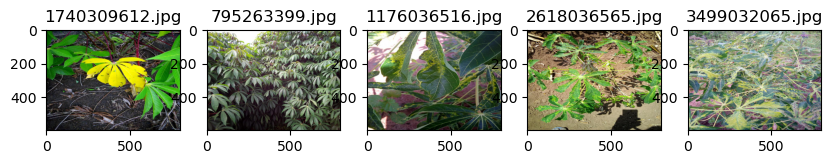

In [16]:
# Visualize raw images
image_dir = path_prefix + 'train_images' 
image_files = os.listdir(image_dir)
num_images = 5
sample_images = random.sample(image_files, num_images)
fig, axs = plt.subplots(1, num_images, figsize=(10, 5))
for i, image_file in enumerate(sample_images):
    image_path = os.path.join(image_dir, image_file)
    image = Image.open(image_path)
    if i == 0:
        print(f"original image size: {image.size}")
    axs[i].imshow(image)
    axs[i].set_title(image_file)
plt.show()

### 1.2 Evalutation (Alan)

## 2. Fine-tuning Kaggle Solution

### 2.1 Implementation (Qihang)

#### Data Preparation

<AxesSubplot:>

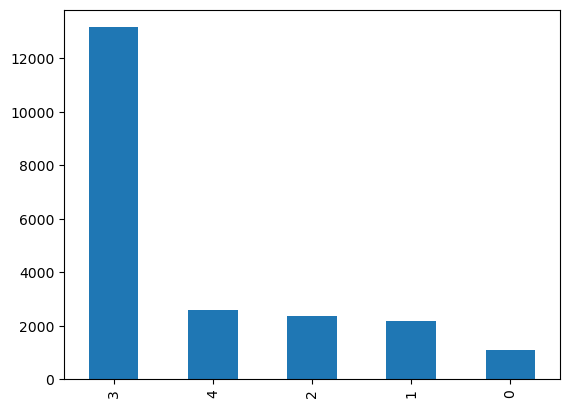

In [17]:
# show the label distribution in train
train['label'].value_counts().plot(kind='bar')

since the data is not very balanced, we may need to use some data augmentation techniques to balance the data.

#### base VIT Model

basic data load, seed and transform adpot from [here](https://www.kaggle.com/code/abhinand05/vision-transformer-vit-tutorial-baseline/notebook#notebook-container)

In [18]:
def seed_everything(seed):
    """
    Seeds basic parameters for reproductibility of results
    
    Arguments:
        seed {int} -- Number of the seed
    """
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


seed_everything(1001)

In [19]:
class CassavaDataset(torch.utils.data.Dataset):
    """
    Helper Class to create the pytorch dataset
    """

    def __init__(self, df = train, data_path= path_prefix, mode="train", transforms=None):
        super().__init__()
        self.df_data = df.values
        self.data_path = data_path
        self.transforms = transforms
        self.mode = mode
        self.data_dir = "train_images" if mode == "train" else "test_images"

    def __len__(self):
        return len(self.df_data)

    def __getitem__(self, index):
        img_name, label = self.df_data[index]
        img_path = os.path.join(self.data_path, self.data_dir, img_name)
        img = Image.open(img_path).convert("RGB")

        if self.transforms is not None:
            image = self.transforms(img)

        return image, label


Conduct multiple transform on training image to generalize the model

In [20]:
# create image augmentations
import torchvision.transforms as transforms

IMG_SIZE = 224

transforms_train = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.RandomHorizontalFlip(p=0.3),
        transforms.RandomVerticalFlip(p=0.3),
        transforms.RandomResizedCrop(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

transforms_valid = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]
)

In [21]:
import timm
print("Available Vision Transformer Models: ")
timm.list_models("vit*")

d:\conda\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Available Vision Transformer Models: 


['vit_base_patch8_224',
 'vit_base_patch8_224_dino',
 'vit_base_patch8_224_in21k',
 'vit_base_patch16_18x2_224',
 'vit_base_patch16_224',
 'vit_base_patch16_224_dino',
 'vit_base_patch16_224_in21k',
 'vit_base_patch16_224_miil',
 'vit_base_patch16_224_miil_in21k',
 'vit_base_patch16_224_sam',
 'vit_base_patch16_384',
 'vit_base_patch16_plus_240',
 'vit_base_patch16_rpn_224',
 'vit_base_patch32_224',
 'vit_base_patch32_224_clip_laion2b',
 'vit_base_patch32_224_in21k',
 'vit_base_patch32_224_sam',
 'vit_base_patch32_384',
 'vit_base_patch32_plus_256',
 'vit_base_r26_s32_224',
 'vit_base_r50_s16_224',
 'vit_base_r50_s16_224_in21k',
 'vit_base_r50_s16_384',
 'vit_base_resnet26d_224',
 'vit_base_resnet50_224_in21k',
 'vit_base_resnet50_384',
 'vit_base_resnet50d_224',
 'vit_giant_patch14_224',
 'vit_giant_patch14_224_clip_laion2b',
 'vit_gigantic_patch14_224',
 'vit_huge_patch14_224',
 'vit_huge_patch14_224_clip_laion2b',
 'vit_huge_patch14_224_in21k',
 'vit_large_patch14_224',
 'vit_large_

#### VIT Model

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [23]:
from torch.cuda.amp import autocast, GradScaler

class VitClassifier(nn.Module):
    def __init__(self, model_name="vit_base_patch16_224", n_classes=5, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_name, pretrained=pretrained)
        n_features = self.model.head.in_features
        self.model.head = nn.Linear(n_features, n_classes)
        
        self.best_val_loss = float('inf')  # initialize best validation loss to infinity
        self.early_stopping_rounds = 3  # number of epochs to wait before early stopping
        self.epochs_without_improvement = 0  # number of epochs without improvement
        
        self.scaler = GradScaler()  # initialize GradScaler
    
    def forward(self, x):
        x = self.model(x)
        return x
    
    def train(self, loader, optimizer, criterion, device, val_loader=None):
        self.model.train()
        train_loss = 0
        train_acc = 0
        for batch in loader:
            optimizer.zero_grad()
            data, target = batch
            data, target = data.to(device), target.to(device)
            
            # Use autocast to perform automatic mixed precision training
            with autocast():
                output = self.model(data)
                loss = criterion(output, target)
            
            # Scales the loss to avoid underflow or overflow
            self.scaler.scale(loss).backward()
            self.scaler.step(optimizer)
            self.scaler.update()
            
            train_loss += loss.item()
            train_acc += (output.argmax(1) == target).sum().item()
        
        train_loss /= len(loader)
        train_acc /= len(loader.dataset)
        
        # Check validation loss and update early stopping counter
        if val_loader is not None:
            val_loss, val_acc = self.evaluate(val_loader, criterion, device)
            if val_loss < self.best_val_loss:
                self.best_val_loss = val_loss
                self.epochs_without_improvement = 0
            else:
                self.epochs_without_improvement += 1
        
        # Check if early stopping criterion is met
        if self.epochs_without_improvement >= self.early_stopping_rounds:
            print(f'Validation loss has not improved in {self.early_stopping_rounds} epochs. Early stopping...')
            return train_loss, train_acc, True
        else:
            return train_loss, train_acc, False

#### Train

In [24]:
train_data, valid_data = train_test_split(train, test_size=0.2, random_state=42, stratify=train.label.values)

In [25]:
BATCH_SIZE = 8
NUM_WORKERS = 4

train_data_loader = torch.utils.data.DataLoader(
    CassavaDataset(df=train_data, transforms=transforms_train),
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=NUM_WORKERS,
)

valid_data_loader = torch.utils.data.DataLoader(
    CassavaDataset(df=valid_data, transforms=transforms_valid),
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=NUM_WORKERS,
)

In [26]:
from tqdm import tqdm
import time

model = VitClassifier(model_name="vit_base_patch16_224", n_classes=5, pretrained=True)

model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

criterion = nn.CrossEntropyLoss()


def train(model, optimizer, criterion, train_loader, val_loader, device, epochs=1):
    print(f"total train epochs: {epochs}")
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    start_time = time.time()
    for epoch in tqdm(range(epochs)):
        print(f"Epoch: {epoch + 1}  / {epochs}")
        train_loss, train_acc = model.train(train_loader, optimizer, criterion, device)
        val_loss, val_acc = model.evaluate(val_loader, criterion, device)
        print(f"Epoch: {epoch + 1} | Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}")
        train_losses.append(train_loss)
        train_accs.append(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)
    
    time_elapsed = time.time() - start_time
    print(f"Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s")
    return train_losses, train_accs, val_losses, val_accs

train_losses, train_accs, val_losses, val_accs = train(model, optimizer, criterion, train_data_loader, valid_data_loader, device, epochs=1)

plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="val loss")
plt.legend()
plt.show()

plt.plot(train_accs, label="train acc")
plt.plot(val_accs, label="val acc")
plt.legend()
plt.show()


d:\conda\lib\site-packages\torch\cuda\amp\grad_scaler.py:120: UserWarning: torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.
  warnings.warn("torch.cuda.amp.GradScaler is enabled, but CUDA is not available.  Disabling.")


total train epochs: 1


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch: 1  / 1


In [ ]:
#save model
torch.save(model.state_dict(), "vit_base_patch16_224.pth")

#save loss and acc into csv

import pandas as pd
df = pd.DataFrame({'train_loss':train_losses, 'train_acc':train_accs, 'val_loss':val_losses, 'val_acc':val_accs})
df.to_csv('vit_base_patch16_224.csv', index=False)


### 2.2 Evaluation (Alan)